Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,383,233 (5.28 MB)

 Trainable params: 1,383,233 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9278 - loss: 0.1879 - val_accuracy: 0.9537 - val_loss: 0.3622
Epoch 2/15
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9811 - loss: 0.0739 - val_accuracy: 0.9655 - val_loss: 0.4066
Epoch 3/15
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9841 - loss: 0.0540 - val_accuracy: 0.9627 - val_loss: 0.5019
Epoch 4/15
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.9835 - loss: 0.0477 - val_accuracy: 0.9613 - val_loss: 0.3699
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.12      0.22     13134
           1       0.50      1.00      0.67     11573

    accuracy                           0.53     24707
   macro avg       0.74      0.56      0.44     24707
weighted avg       0.75      0.53      0.43     24707


Confusion Matrix:
[[ 1598 11536]
 [   40 11533]]


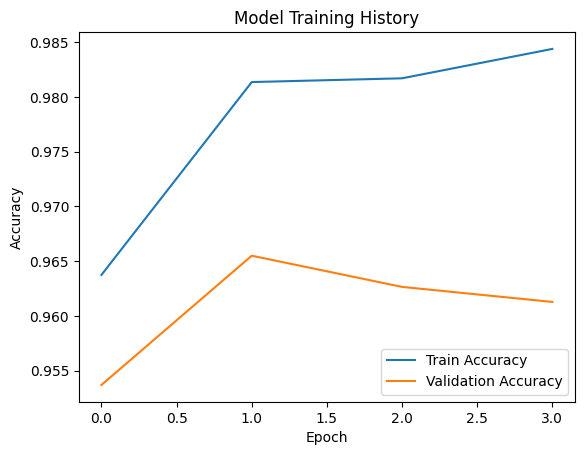

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Custom Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                               shape=(input_shape[-1], 1),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(name='attention_bias',
                               shape=(input_shape[1], 1),
                               initializer='zeros',
                               trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        at = tf.nn.softmax(et, axis=1)
        at = tf.transpose(at, perm=[0,2,1])
        output = tf.matmul(at, x)
        return tf.squeeze(output, axis=1)

# Load datasets
train_df = pd.read_csv('trainingdata.csv')
test_df = pd.read_csv('testingdata.csv')

# Preprocessing
max_words = 10000
max_len = 128

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Query'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['Query'])
X_test = tokenizer.texts_to_sequences(test_df['Query'])

# Padding sequences
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Labels
y_train = train_df['Label'].values
y_test = test_df['Label'].values

# Model architecture
def create_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=max_words, output_dim=128)(inputs)

    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedding)

    attention = AttentionLayer()(lstm_out)

    dense = Dense(32, activation='relu')(attention)
    dropout = Dropout(0.5)(dense)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluation
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate and print accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5315


In [ ]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

Test Accuracy: 0.5315

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.12      0.22     13134
           1       0.50      1.00      0.67     11573

    accuracy                           0.53     24707
   macro avg       0.74      0.56      0.44     24707
weighted avg       0.75      0.53      0.43     24707


Confusion Matrix:
[[ 1598 11536]
 [   40 11533]]


In [ ]:
model.save('sql_injection_model.h5')

In [ ]:
# Add these lines at the end of your training script
import pickle

# Save tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Custom Attention Layer (must match training code)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                               shape=(input_shape[-1], 1),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(name='attention_bias',
                               shape=(input_shape[1], 1),
                               initializer='zeros',
                               trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        at = tf.nn.softmax(et, axis=1)
        at = tf.transpose(at, perm=[0,2,1])
        output = tf.matmul(at, x)
        return tf.squeeze(output, axis=1)

# Load model and tokenizer
model = tf.keras.models.load_model('sql_injection_model.h5',
                                  custom_objects={'AttentionLayer': AttentionLayer})

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Prediction parameters (must match training)
max_len = 128

def predict_injection():
    while True:
        query = input("\nEnter SQL query (or 'exit' to quit): ")
        if query.lower() == 'exit':
            break

        # Preprocess input
        sequence = tokenizer.texts_to_sequences([query])
        padded = pad_sequences(sequence, maxlen=max_len, padding='post')

        # Predict
        prediction = model.predict(padded, verbose=0)
        probability = prediction[0][0]
        result = "SQL Injection Detected!" if probability > 0.5 else "Safe Query"

        print(f"\nResult: {result}")
        print(f"Confidence: {probability:.4f}")
        print("-" * 50)

if __name__ == "__main__":
    print("SQL Injection Detection System")
    print("Enter SQL queries to analyze (type 'exit' to quit)")
    predict_injection()

SQL Injection Detection System
Enter SQL queries to analyze (type 'exit' to quit)

Enter SQL query (or 'exit' to quit): 1%')) union all select null,null,null,null,null#

Result: SQL Injection Detected!
Confidence: 0.9999
--------------------------------------------------

Enter SQL query (or 'exit' to quit): INSERT INTO automobile ( make, model, year, color, mileage, engine_size, transmission,

Result: Safe Query
Confidence: 0.1714
--------------------------------------------------

Enter SQL query (or 'exit' to quit): XVAlThLc5NUBY1BoA4REXVAlThLc5NUBY1BoA4REXVAlThLc5NUBY1BoA4REXVAlThLc5NUBY1BoA4REXVAlThLc5NUBY1BoA4REXVAlThLc5NUBY1Bo

Result: Safe Query
Confidence: 0.1441
--------------------------------------------------

Enter SQL query (or 'exit' to quit): exit


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98275 entries, 0 to 98274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   98275 non-null  object
 1   Label   98275 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import pickle

# Custom Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                               shape=(input_shape[-1], 1),
                               initializer='glorot_normal',
                               trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.matmul(x, self.W))
        at = tf.nn.softmax(et, axis=1)
        output = tf.reduce_sum(x * at, axis=1)
        return output

# SQL-specific preprocessing
def preprocess_query(query):
    query = re.sub(r"'(.*?)'", "'?'", query)  # Mask strings
    query = re.sub(r"\b\d+\b", "?", query)     # Mask numbers
    query = re.sub(r";\s*--", ";--", query)    # Standardize comments
    return query.strip()

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return 0.001
    return 0.0001

# Load and preprocess data
train_df = pd.read_csv('trainingdata.csv')
test_df = pd.read_csv('testingdata.csv')

# Apply preprocessing
train_df['Processed'] = train_df['Query'].apply(preprocess_query)
test_df['Processed'] = test_df['Query'].apply(preprocess_query)

# Tokenization
max_words = 15000
max_len = 256

tokenizer = Tokenizer(num_words=max_words, oov_token='[UNK]', filters='')
tokenizer.fit_on_texts(train_df['Processed'])

# Sequence conversion
X_train = tokenizer.texts_to_sequences(train_df['Processed'])
X_test = tokenizer.texts_to_sequences(test_df['Processed'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')
y_train = train_df['Label'].values
y_test = test_df['Label'].values

# Class balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Add adversarial examples
adversarial_queries = [
    "admin' OR ?=?--",
    "' UNION SELECT * FROM ?--",
    "?; DROP TABLE ?--",
    "SELECT ?? FROM ? WHERE ?=?--"
]
adv_sequences = tokenizer.texts_to_sequences(adversarial_queries)
X_adv = pad_sequences(adv_sequences, maxlen=max_len, padding='post')
X_res = np.vstack([X_res, X_adv])
y_res = np.concatenate([y_res, np.ones(len(adversarial_queries))])

# Model architecture
def create_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=256)(inputs)

    # Bidirectional layers
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Attention
    x = AttentionLayer()(x)

    # Classifier
    x = Dense(64, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.6)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

model = create_model()

# Training
early_stop = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')
lr_callback = LearningRateScheduler(lr_scheduler)

history = model.fit(
    X_res, y_res,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop, lr_callback],
    class_weight={0: 2.5, 1: 0.7}  # Penalize false negatives
)

# Threshold tuning
y_pred_probs = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(precisions + recalls)
optimal_threshold = thresholds[optimal_idx]

# Evaluation
y_pred = (y_pred_probs > optimal_threshold).astype(int)

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save artifacts
model.save('improved_model.h5')
with open('tokenizer_2.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 69s 90ms/step - auc: 0.9417 - loss: 0.5615 - precision: 0.9743 - recall: 0.8065 - val_auc: 0.9386 - val_loss: 0.6685 - val_precision: 0.0012 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - auc: 0.9938 - loss: 0.0806 - precision: 0.9981 - recall: 0.9728 - val_auc: 0.8728 - val_loss: 1.6894 - val_precision: 6.3121e-04 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - auc: 0.9963 - loss: 0.0644 - precision: 0.9985 - recall: 0.9752 - val_auc: 0.8926 - val_loss: 1.5613 - val_precision: 6.6138e-04 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - auc: 0.9968 - loss: 0.0538 - precision: 0.9986 - recall: 0.9802 - val_auc: 0.8820 - val_loss: 1.7612 - val_precision: 5.7712e-04 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 62s 88ms/step - auc: 0.9976 - loss: 0.0460 -

Optimal Threshold: 0.0070

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.06      0.12     13134
           1       0.48      1.00      0.65     11573

    accuracy                           0.50     24707
   macro avg       0.74      0.53      0.39     24707
weighted avg       0.76      0.50      0.37     24707


Confusion Matrix:
[[  844 12290]
 [    5 11568]]


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate and print accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5024
